### Facultad de Ciencias Exactas, Ingeniería y Agrimensura - UNR
## Tenicatura Universitaria en Inteligencia Artificial.


# Trabajo Práctico Final: Procesamiento de Lenguaje Natural.

- **Pace, Bruno. Legajo: P-5295/7.**

Docentes:
 - Manson, Juan Pablo.
 - Geary, Alan.
 - Sollberger, Dolores.
 - Ferrucci, Costantino.

Fecha de Entrega: 15 de diciembre de 2024.


In [1]:
# Redis graph
%%capture
!pip install redis redisgraph
!wget http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!curl -fsSL https://packages.redis.io/redis-stack/redis-stack-server-6.2.6-v7.focal.x86_64.tar.gz -o redis-stack-server.tar.gz
!tar -xvf redis-stack-server.tar.gz
!./redis-stack-server-6.2.6-v7/bin/redis-stack-server --daemonize yes


import redis
from redisgraph import Graph, Node, Edge
import matplotlib.pyplot as plt
import networkx as nx

# Selenium web scrapping
!apt-get update
!apt-get install -y chromium-browser chromium-chromedriver
!pip install selenium

#!apt-get install -y xvfb
#!pip install pyvirtualdisplay

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import os
os.environ["PATH"] += ":/usr/bin/chromedriver"

# Extracción de texto desde Documentos
!pip install PyPDF2
import PyPDF2

# Visualización
import matplotlib.pyplot as plt
import networkx as nx

# DataFrame
import pandas as pd

# Requests (Descarga de PDF)
import requests

# YouTube Transcripción
!pip install youtube-transcript-api
from youtube_transcript_api import YouTubeTranscriptApi

# Base de Datos de Grafo

## Web scrapping
Se obtiene información a través de Web Scrapping con Selenium.
Se tiene la siguiente información:
- Diseñadores.
- Artistas.
- Familia de Juegos.
- Mecanismos.
- Empresas que lo publicaron.
- Categorias.

In [2]:
url_grafo: str = "https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/credits"
title: str = 'Rajas Of The Ganges'

In [3]:
def buscar_credito(data: str) -> tuple[dict[str, list[str]], dict[str,list[str]]]:
    """
    Retorna una tupla de diccionarios que contienen el(los) nombre(s) y el link(s) correspondiente(s)

    Args:
      data: str = el nombre del dato a buscar

    Returns:
      name_dict: dict[str, list[str]] = diccionario con los nombres.
      link_dict: dict[str, list[str]] = diccionario con los links.
    """
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    driver = webdriver.Chrome(service=Service(), options=chrome_options)
    driver.get(url_grafo)

    name_dict: dict[str, list[str]] = {f"{data}_nombre": []}
    link_dict: dict[str, list[str]] = {f"{data}_link": []}

    elements = driver.find_elements(By.XPATH, f'//a[contains(@ng-href, "/boardgame{data}/")]')

    if elements:
        for element in elements:
            name_dict[f"{data}_nombre"].append(element.text)
            link_dict[f"{data}_link"].append(element.get_attribute('href'))
    else:
        print(f"No se encontraron elementos para {data}")

    driver.quit()

    return name_dict, link_dict

data_designer: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("designer")
data_artist: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("artist")
data_family: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("family")
data_mechanic: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("mechanic")
data_publisher: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("publisher")
data_categories: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("category")

In [4]:
data_categories[0]

{'category_nombre': ['Dice', 'Economic', 'Renaissance', 'Territory Building']}

## Creación de BBDD de Grafos
Se utiliza Redis, por su simple implementación con Colab.

In [5]:
redis_client = redis.Redis(host='localhost', port=6379) # inicialización de Redis

In [6]:
def define_relation(label: str) -> str | None:
  """
  Define la relación entre el nodo titulo y el nodo que se quiere relacionar

  Args:
    label: str = el label del nodo que se quiere relacionar

  Returns:
    str | None = el label de la relación
  """
  if label == "Designer":
    return "Designed_by"
  elif label == "Artist":
    return "Created_by"
  elif label == "Family":
    return "Similar_to"
  elif label == "Mechanic":
    return "Mechanic"
  elif label == "Published_by":
    return "Published by"
  elif label == "Category":
    return "Category"
  return None

In [7]:
def crear_nodos_with_edges(graph: Graph, data: dict[str, list[str]], main_node: Node) -> None:
    """
    Dado un diccionario con datos, crea los nodos correspondientes en un grafo
    de redis y añade las relaciones correspondientes.

    Args:
        graph: Redis graph instance.
        data: Dictionary containing names as lists under specific keys.
        main_node: The main node to relate new nodes with.

    Returns:
        None
    """
    if not data:
        print("Diccionario vacío")
        return

    for key, names in data[0].items():
        label = key.split("_")[0].capitalize()
        relation = define_relation(label)

        if not relation:
            print(f"Relación no definida para el label: {label}")
            continue

        for name in names:
            print(f'Creando nodo con nombre: {name} y label: {label}')
            node = Node(label=label, properties={"name": name})
            graph.add_node(node)

            print(f'Añadiendo relación: {relation}')
            edge = Edge(main_node, relation, node)
            edge.relattion_type = relation
            graph.add_edge(edge)

    print("Nodos y relaciones creados exitosamente.")
    return None

In [8]:
graph = Graph('creditos', redis_client)

def create_all_nodes(graph: Graph) -> None:
  """
  Crea los nodos del grafo.
  Args:
    graph: grafo de redis.

  Returns:
    None
  """
  main_node = Node(label='title', properties={"name": title})
  graph.add_node(main_node)
  crear_nodos_with_edges(graph, data_designer, main_node)
  crear_nodos_with_edges(graph, data_artist, main_node)
  crear_nodos_with_edges(graph, data_family, main_node)
  crear_nodos_with_edges(graph, data_mechanic, main_node)
  crear_nodos_with_edges(graph, data_publisher, main_node)
  graph.commit()
  return None

create_all_nodes(graph)

Creando nodo con nombre: Inka Brand y label: Designer
Añadiendo relación: Designed_by
Creando nodo con nombre: Markus Brand y label: Designer
Añadiendo relación: Designed_by
Nodos y relaciones creados exitosamente.
Creando nodo con nombre: Dennis Lohausen y label: Artist
Añadiendo relación: Created_by
Nodos y relaciones creados exitosamente.
Creando nodo con nombre: Admin: Better Description Needed! y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Country: India y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Digital Implementations: Tabletopia y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Digital Implementations: Yucata y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Game: Rajas of the Ganges y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Mechanism: Dice Drafting y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Religious: Hinduism y label: Fa

In [9]:
def get_all_nodes(graph: Graph) -> list[dict]:
    """
    Devuelve todos los nodos del grafo

    Args:
        graph: grafo de redis

    Returns:
        Lista de diccionarios con id, label y properties de cada nodo.
    """
    query = "MATCH (n) RETURN n"
    result = graph.query(query)
    nodes: list = []

    for record in result.result_set:
        node = record[0]
        node_data = {
            "id": node.id,
            "label": node.label,
            "properties": node.properties
        }
        nodes.append(node_data)

    return nodes

all_nodes = get_all_nodes(graph)
for node in all_nodes:
    print(node)

{'id': 0, 'label': 'title', 'properties': {'name': 'Rajas Of The Ganges'}}
{'id': 1, 'label': 'Designer', 'properties': {'name': 'Inka Brand'}}
{'id': 2, 'label': 'Designer', 'properties': {'name': 'Markus Brand'}}
{'id': 3, 'label': 'Artist', 'properties': {'name': 'Dennis Lohausen'}}
{'id': 4, 'label': 'Family', 'properties': {'name': 'Admin: Better Description Needed!'}}
{'id': 5, 'label': 'Family', 'properties': {'name': 'Country: India'}}
{'id': 6, 'label': 'Family', 'properties': {'name': 'Digital Implementations: Tabletopia'}}
{'id': 7, 'label': 'Family', 'properties': {'name': 'Digital Implementations: Yucata'}}
{'id': 8, 'label': 'Family', 'properties': {'name': 'Game: Rajas of the Ganges'}}
{'id': 9, 'label': 'Family', 'properties': {'name': 'Mechanism: Dice Drafting'}}
{'id': 10, 'label': 'Family', 'properties': {'name': 'Religious: Hinduism'}}
{'id': 11, 'label': 'Mechanic', 'properties': {'name': 'Connections'}}
{'id': 12, 'label': 'Mechanic', 'properties': {'name': 'Dice 

()-[:Designed_by]->()
()-[:Designed_by]->()
()-[:Created_by]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-[:Designed_by]->()
()-[:Designed_by]->()
()-[:Created_by]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-[:Designed_by]->()
()-[:Designed_by]->()
()-[:Created_by]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Similar_to]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-[:Mechanic]->()
()-

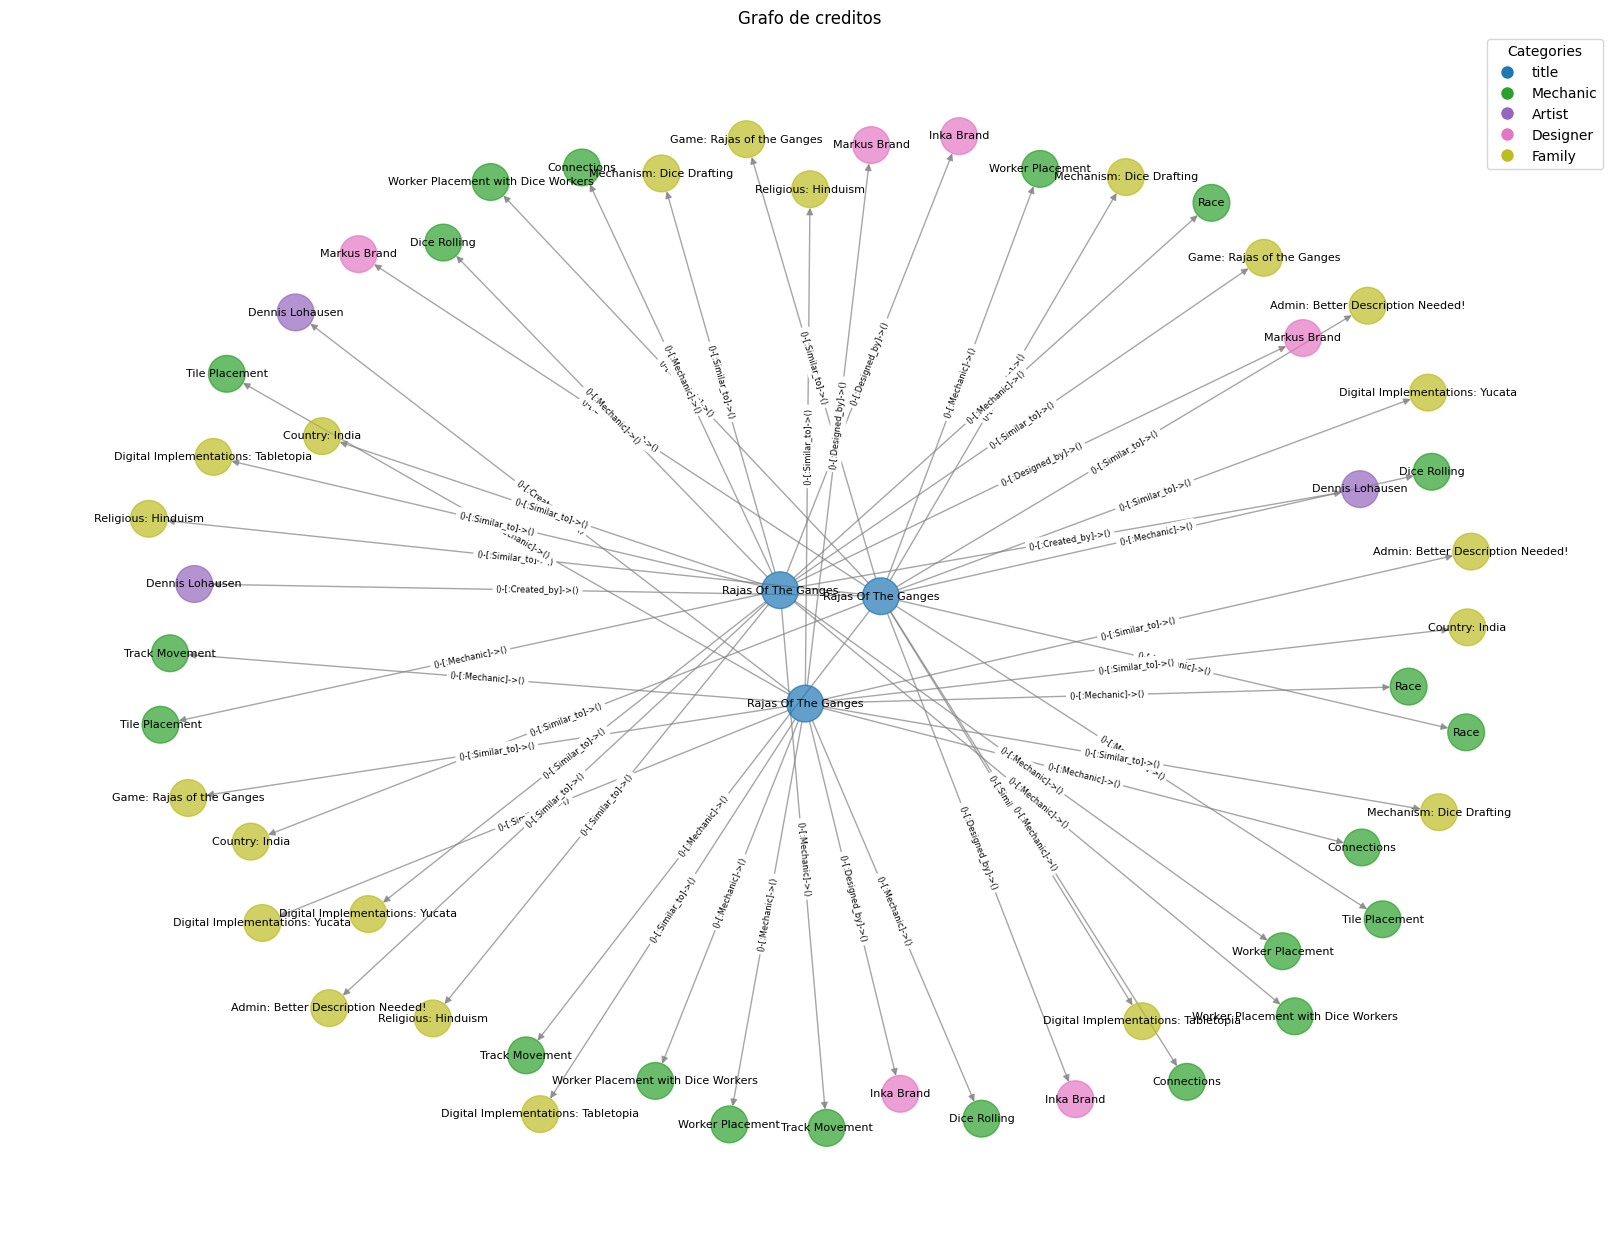

In [10]:
def plot_graph(graph: Graph) -> None:
    """
    Plot de un grafo de redis con sus relaciones

    Args:
        graph: grafo de redis

    Returns:
        None
    """
    nx_graph = nx.DiGraph()

    node_query = "MATCH (n) RETURN n"
    node_result = graph.query(node_query)

    for record in node_result.result_set:
        node = record[0]
        node_id = node.id
        node_label = node.label
        node_name = node.properties.get("name", f"Node {node_id}")
        nx_graph.add_node(node_id, label=node_label, name=node_name, category=node_label)

    edge_query = "MATCH (n)-[r]->(m) RETURN n, r, m"
    edge_result = graph.query(edge_query)

    for record in edge_result.result_set:
        #print(f' record 0: {record[0]}')
        #print(f' record 1: {record[1]}')
        #print(f' record 2: {record[2]}')
        src = record[0].id
        dest = record[2].id
        relationship = record[1]
        print(relationship)
        nx_graph.add_edge(src, dest, label=relationship)

    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(nx_graph, k=0.5)

    categories = nx.get_node_attributes(nx_graph, 'category')
    unique_categories = set(categories.values())
    node_colors = {cat: plt.cm.tab10(i / len(unique_categories)) for i, cat in enumerate(unique_categories)}
    node_color_list = [node_colors[categories[node]] for node in nx_graph.nodes()]

    nx.draw(
        nx_graph, pos,
        with_labels=False,
        node_size=700,
        node_color=node_color_list,
        edge_color='gray',
        alpha=0.7
    )

    node_labels = {node: data['name'] for node, data in nx_graph.nodes(data=True)}
    nx.draw_networkx_labels(nx_graph, pos, labels=node_labels, font_size=8, font_color='black')

    edge_labels = nx.get_edge_attributes(nx_graph, "label")
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=6)

    legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cat)
                     for cat, color in node_colors.items()]
    plt.legend(handles=legend_labels, loc='best', title='Categories')

    plt.title("Grafo de creditos")
    plt.show()

plot_graph(graph)

# BBDD Tabular

In [11]:
url_stats: str = 'https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/stats'

In [12]:
def get_stats(url: str) -> dict:
    """
    Dado un URL obtiene las estadisticas de un juego.

    Args:
        url: URL de las estadísticas.

    Returns:
        Diccionario con las estadisticas.
    """
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    driver = webdriver.Chrome(service=Service(), options=chrome_options)
    driver.get(url)

    stats: dict[str, dict[str, str]] = {}

    try:
        WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'li.outline-item')))

        elements = driver.find_elements(By.CSS_SELECTOR, 'li.outline-item')



        for element in elements:
            main_text_element = element.find_element(By.CSS_SELECTOR, 'div.outline-item-title')
            main_text = main_text_element.text.strip()

            #stats[main_text] = {}

            sub_value = element.find_element(By.CSS_SELECTOR, 'div.outline-item-description').text.strip()

            stats[main_text] = sub_value

    except Exception as e:
        print(f"Error extracting stats: {e}")
    finally:
        driver.quit()

    return stats

stats = get_stats(url_stats)
print(stats)


{'Avg. Rating': '7.730', 'No. of Ratings': '14,688', 'Std. Deviation': '1.13', 'Weight': '2.89 / 5', 'Comments': '2,121', 'Fans': '690', 'Page Views': '897,573', 'Overall Rank': '154\nHistorical Rank', 'Strategy Rank': '123\nHistorical Rank', 'All Time Plays': '59,331', 'This Month': '133', 'Own': '19,540', 'Prev. Owned': '2,049', 'For Trade': '194\nFind For-Trade Matches', 'Want In Trade': '676\nFind Want-in-Trade Matches', 'Wishlist': '3,805', 'Has Parts': '11', 'Want Parts': '4'}


In [13]:
df_stats: pd.DataFrame = pd.DataFrame(stats, index=[0])
df_stats

,Avg. Rating,No. of Ratings,Std. Deviation,Weight,Comments,Fans,Page Views,Overall Rank,Strategy Rank,All Time Plays,This Month,Own,Prev. Owned,For Trade,Want In Trade,Wishlist,Has Parts,Want Parts
0,7.730,"14,688",1.13,2.89 / 5,"2,121",690,"897,573",154\nHistorical Rank,123\nHistorical Rank,"59,331",133,"19,540","2,049",194\nFind For-Trade Matches,676\nFind Want-in-Trade Matches,"3,805",11,4


In [14]:
df_stats.columns

Index(['Avg. Rating', 'No. of Ratings', 'Std. Deviation', 'Weight', 'Comments',
       'Fans', 'Page Views', 'Overall Rank', 'Strategy Rank', 'All Time Plays',
       'This Month', 'Own', 'Prev. Owned', 'For Trade', 'Want In Trade',
       'Wishlist', 'Has Parts', 'Want Parts'],
      dtype='object')

In [15]:
columns_renamed: dict[str, str] = {
    'Avg. Rating': 'average_rating',
    'No. of Ratings': 'number_of_rating',
    'Std. Deviation' : 'std',
    'Weight' : 'weight',
    'Comments' : 'comments',
    'Fans' : 'fans',
    'Page Views' : 'page_views',
    'Overall Rank': 'overall_rank',
    'Strategy Rank' : 'strategy_rank',
    'All Time Plays' : 'all_time_plays',
    'This Month' : 'this_month',
    'Own': 'own',
    'Prev. Owned' : 'owned_no_longer',
    'For Trade' : 'items_for_trade',
    'Want In Trade' : 'items_want_in_trade',
    'Wishlist' : 'wishlist',
    'Has Parts' :'people_who_has_parts_to_exchange',
    'Want Parts' : 'people_who_want_parts_to_exchange'

}

df_stats_renamed = pd.DataFrame(df_stats.rename(columns=columns_renamed))
df_stats_renamed

,average_rating,number_of_rating,std,weight,comments,fans,page_views,overall_rank,strategy_rank,all_time_plays,this_month,own,owned_no_longer,items_for_trade,items_want_in_trade,wishlist,people_who_has_parts_to_exchange,people_who_want_parts_to_exchange
0,7.730,"14,688",1.13,2.89 / 5,"2,121",690,"897,573",154\nHistorical Rank,123\nHistorical Rank,"59,331",133,"19,540","2,049",194\nFind For-Trade Matches,676\nFind Want-in-Trade Matches,"3,805",11,4


In [16]:
columns_with_noise: list[str] = ['items_for_trade','overall_rank','strategy_rank','items_want_in_trade']

def delete_noise(column: str) -> str:
  return column[:3]

df_stats_cleaned: pd.DataFrame = df_stats_renamed.copy()

for column in columns_with_noise:
  df_stats_cleaned[column] = df_stats_cleaned[column].apply(delete_noise)

df_stats_cleaned

,average_rating,number_of_rating,std,weight,comments,fans,page_views,overall_rank,strategy_rank,all_time_plays,this_month,own,owned_no_longer,items_for_trade,items_want_in_trade,wishlist,people_who_has_parts_to_exchange,people_who_want_parts_to_exchange
0,7.730,"14,688",1.13,2.89 / 5,"2,121",690,"897,573",154,123,"59,331",133,"19,540","2,049",194,676,"3,805",11,4


In [17]:
df_stats_long: pd.DataFrame = pd.melt(df_stats_cleaned, var_name='Stat', value_name='Value')

df_stats_long

,Stat,Value
0,average_rating,7.730
1,number_of_rating,"14,688"
2,std,1.13
3,weight,2.89 / 5
4,comments,"2,121"
5,fans,690
6,page_views,"897,573"
7,overall_rank,154
8,strategy_rank,123
9,all_time_plays,"59,331"


# Documentos de texto

In [18]:
def get_pdf(url: str, filename: str) -> None:
  """
  Dado un url de un pdf y un nombre para almacenarlo, lo descarga y lo guarda.

  Args:
    url: url del pdf.
    filename: nombre del pdf.

  Returns:
    None
  """
  response = requests.get(url)
  if response.status_code == 200:
      with open(f'{filename}.pdf', "wb") as file:
          file.write(response.content)
      print("PDF downloaded successfully.")
  else:
      print("Failed to download the PDF.")
  return None

get_pdf('https://github.com/bpace1/TUIA---NLP/raw/047d8fd1402bd9e65122f36381316e7074361023/TP2-Final/data/review.pdf', 'review')
get_pdf('https://github.com/bpace1/TUIA---NLP/raw/047d8fd1402bd9e65122f36381316e7074361023/TP2-Final/data/rulebook.pdf', 'rulebook')

PDF downloaded successfully.
PDF downloaded successfully.


In [19]:
def pdf_to_text(pdf_path: str) -> str:
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)

        text = ''
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            page_text = page.extract_text()

            filtered_text = ' '.join(line for line in page_text.split('\n') if len(line.strip()) >= 3)

            text += filtered_text + ' '

        return text.strip()

review_text: str = pdf_to_text('review.pdf')
rulebook_text: str = pdf_to_text('rulebook.pdf')

In [20]:
review_text

'Rajas of the Ganges Review Board Games Huch! Inka Brand Markus Brand Worker Placement20 2023 Home Reviews Features Videos AboutSearch We use cookies on our website to give you the most relevant experience by remembering your preferences and repeat visits. By clicking “Accept All”, you consent to the use of ALL the cookies.However, you may visit "Cookie Settings" to provide a controlled consent. Cookie Settings Accept AllRajas of the Ganges Review - Board Game Review https://boardgamereview.co.uk/game-reviews/rajas-of-the-ganges-boa... 1 de 19 12/12/2024, 8:15 Set at the peak of the Mogul empire on the banks of the most sacred river in India, Rajas of the Ganges is a dice worker placement game released in 2017. That’s right I am onceagain bringing you the latest hotness, just six years too late! Designed by Inka andMarkus Brand, a duo perhaps better known for their Exit: The Game range. As regular readers of my reviews know, I quite often pair board games to music, like a sommelier pai

In [21]:
rulebook_text

'India in the era of the aspiring Mogul empire. New lands are being gained along with great prosperity attained through the trading of silk, tea, and  spices. Imposing structures such as the Taj Mahal and the Red Fort are built, and gorgeous gardens are created alongside new buildings and parks  that will impress generations to come even centuries later. At a time when the empire has almost reached its greatest dimensions and is in a phase of relative stability, players, representing rajas and ranis,  are called upon to live up to the requirements of their role as venerable sovereigns. They must improve their estates into magnificent and wealthy  provinces. Keeping in mind the important role of karma, players balance their growth in a demanding interplay of prestige and prosperity. The one  with the most successful outcome will truly become one of the nation’s legendary leaders. For 2 to 4 players, 12 years and up Contents  Object of the Game Your task is to develop your province with 

# Transcripción de Videos de Youtube
- [¿Cómo se juega?](https://www.youtube.com/watch?v=OJ0anCDdIJ4&t=21s)
- [Review](https://www.youtube.com/watch?v=3-Vo-0Cv9Pk)

Se utiliza la api de transcripción de YouTube.



In [22]:
import re
from youtube_transcript_api import YouTubeTranscriptApi

def transcribe_yt_video(url: str) -> str:
    """
    Dado un URL de un video de YouTube, obtiene los subtítulos.

    Args:
        url: URL del video.

    Returns:
        Texto de los subtítulos.
    """
    try:
        video_id_match = re.search(r"v=([a-zA-Z0-9_-]+)", url)
        if video_id_match:
            video_id = video_id_match.group(1)
        else:
            raise ValueError("No se pudo extraer el ID del video de la URL.")

        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        text = " ".join([entry['text'] for entry in transcript])

        text = text.replace('\n', ' ').strip()

        return text

    except Exception as e:
        print("Error:", e)

how_to_play_video: str = transcribe_yt_video('https://www.youtube.com/watch?v=OJ0anCDdIJ4&t=21s')
review_video: str = transcribe_yt_video('https://www.youtube.com/watch?v=3-Vo-0Cv9Pk')
gameplay_video: str = transcribe_yt_video('https://www.youtube.com/watch?v=ruScGyu1_5w')


In [23]:
gameplay_video

"hi everyone my name is modi and i'm naveen from before you play and today we are going to be doing a playthrough of rogers of the ganges now this is a game that was requested by one of our longtime patreon supporters an executive producer so thank you so much for that this one's designed by two different designers inca and marcus brand and it is published by r r games and hooch and it is a two to four player very euro style game and so we are pretty excited to showcase it today it's interesting because it is definitely a heroes style game but there is some dice rolling there is yup there's quite a bit of dice rolling and so in this game we're going to be building up our province uh in india we're trying to earn a lot of money and fame at the same time and as per usual we are going to start with an overview of how the game is played then we're going to go into our playthrough and then our review of it and so if you're interested in jumping around we will include time stamps down below 

In [24]:
review_video

"and now it's time for another diced our review with Tom vassal hey folks I'm Tom vassal and today we're taking a look at a game by incus and Marcus brand called the Rajah's of the Ganges now the brands have been turning into my favorite duo of designers they've made some really great games this year they made the exit games they made a great party game just good stuff across the board so today we're taking a look at this game here when which what is the theme of this game in 16th century India you are being some Raja and you are going to basically be influential in your area okay a lot of the the hootch games don't really necessarily the theme doesn't matter it's all about mechanisms this one has dice in it dice as a resource in the game and you're going to also beat it has an interesting method of victory where to victory point tracks are going to cross here's how plays okay so here's the board and we want to talk about is there's two tracks on the board there's a thing track you'll 

In [25]:
how_to_play_video

"Hello and welcome to another episode of how to play by Cat House Gaming. Our goal in this series is to give you and your tablemates the foundational game mechanics needed to you playing in a short amount of time. I know you'd rather be gaming so let's get started. Hey guys today's game is Rajas of the Ganges. In Rajas of the Ganges each player is Indian royalty tasked with improving their estates into wealthy provinces through the trading of silk, tea, and spices as well as by building impressive structures to awe current and future generations. Rajas of the Ganges is a game for two to four players combining several game mechanics including worker placement, tile laying, and dice rolling. It has an interesting end game trigger and scoring mechanism. End game is triggered when a user's fame marker passes their money marker. The current stage and not the round is completed which means that all players between the person who triggered end game and the person with with the start player ma

# Base de Datos Vectorial

In [26]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter, MarkdownTextSplitter
import re

def get_chunks(text: str, chunk_size: int = 500, chunk_overlap: int = 30) -> list[str]:
  """
  Dado un texto, un tamaño de chunk y una superposición, devuelve una lista de chunks

  Args:
    text: texto a dividir.
    chunk_size: tamaño del chunk.
    chunk_overlap: superposición entre chunks.

  Returns:
    Lista de chunks.
  """
  splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
  chunks = splitter.split_text(text)
  return chunks

In [27]:
chunks_review: list[str] = get_chunks(review_text)
chunks_rulebook: list[str] = get_chunks(rulebook_text)

chunks_video_review: list[str] = get_chunks(review_video)
chunks_video_gameplay: list[str] = get_chunks(gameplay_video)
chunks_video_how_to_play: list[str] = get_chunks(how_to_play_video)

In [28]:
for chunk in chunks_video_gameplay:
  print(chunk)
  print('\n')

hi everyone my name is modi and i'm naveen from before you play and today we are going to be doing a playthrough of rogers of the ganges now this is a game that was requested by one of our longtime patreon supporters an executive producer so thank you so much for that this one's designed by two different designers inca and marcus brand and it is published by r r games and hooch and it is a two to four player very euro style game and so we are pretty excited to showcase it today it's interesting


it today it's interesting because it is definitely a heroes style game but there is some dice rolling there is yup there's quite a bit of dice rolling and so in this game we're going to be building up our province uh in india we're trying to earn a lot of money and fame at the same time and as per usual we are going to start with an overview of how the game is played then we're going to go into our playthrough and then our review of it and so if you're interested in jumping around we will


in

In [29]:
total_chunks: list[list[str]] = [chunks_review, chunks_rulebook, chunks_video_review, chunks_video_gameplay, chunks_video_how_to_play]

Inicialización de chroma con explicación en [Medium](https://gdevakumar-medium-com.translate.goog/quickstart-guide-to-vector-databases-using-chromadb-52587f75cf7f?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc&_x_tr_hist=true)

In [32]:
import chromadb
import uuid
import torch
from transformers import AutoModel, AutoTokenizer

# Cargar el modelo y tokenizador de Transformers (puedes cambiarlo a otro modelo si lo deseas)
embedding_model_name = "distilbert-base-uncased"  # Modelo de ejemplo, puedes cambiarlo a cualquier otro modelo
tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
model = AutoModel.from_pretrained(embedding_model_name)

def get_embedding(chunk: str) -> torch.Tensor:
    """
    Convierte un fragmento de texto (chunk) en un embedding utilizando un modelo de transformers.

    Args:
        chunk: Un fragmento de texto (string).

    Returns:
        Un embedding del chunk de texto como un tensor.
    """
    inputs = tokenizer(chunk, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)

    # Tomamos el embedding del primer token [CLS] como representación del chunk
    embedding = outputs.last_hidden_state[:, 0, :]  # El primer token [CLS]

    return embedding.squeeze().numpy()  # Convertir el tensor a un array de NumPy

# Tu función original, modificada para aceptar embeddings
def add_to_chroma(collection: chromadb.Collection, chunks: list[str], embedding_model) -> None:
    """
    Dado una colección de Chroma y una lista de chunks, los añade a la colección junto con sus embeddings.

    Args:
      collection: colección de Chroma.
      chunks: lista de chunks.
      embedding_model: modelo para generar los embeddings.

    Returns:
      None
    """
    for chunk in chunks:
        chunk_id = str(uuid.uuid4())  # Generar un ID único

        # Obtener el embedding para el chunk
        embedding = get_embedding(chunk)  # Obtener el embedding del chunk

        # Añadir el chunk y su embedding a la colección
        collection.add(
            documents=[chunk],      # El texto del chunk
            embeddings=[embedding],  # El embedding generado
            metadatas=[{"id": chunk_id}],  # Metadatos con el ID
            ids=[chunk_id]          # ID único para el chunk
        )
    return None

# Función para insertar todos los chunks (de listas de chunks)
def add_all_chunks(list_of_chunks: list[list[str]], collection: chromadb.Collection, embedding_model) -> None:
    """
    Dado una lista de listas de chunks, inserta sus embeddings en la colección de Chroma.

    Args:
      list_of_chunks: lista de listas de chunks de texto.
      collection: colección de Chroma.
      embedding_model: modelo para generar los embeddings.

    Returns:
      None
    """
    for chunks in list_of_chunks:
        add_to_chroma(collection, chunks, embedding_model)  # Insertar los chunks y sus embeddings
    return None

chroma_client = chromadb.Client()
collection = chroma_client.get_or_create_collection(name="game_embeddings")


add_all_chunks(total_chunks, collection, model)
